In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import pickle

In [2]:
features = pd.read_csv('data/features_data_set.csv')
stores = pd.read_csv('data/stores_data_set.csv')
sales = pd.read_csv('data/sales_data_set.csv')

In [3]:
summary = pd.merge(sales, features.loc[:, features.columns != 'IsHoliday'],how = 'left', on = ['Store','Date'])

In [4]:
summary = pd.merge(summary, stores, how = 'left', on = ['Store'])

In [5]:
summary['Weekly_Sales'] = np.where(summary['Weekly_Sales'] < 0, 0, summary['Weekly_Sales'])

In [6]:
summary.fillna(0, inplace=True)

In [7]:
summary['Date'] = pd.to_datetime(summary['Date'], format='%d/%m/%Y')
summary['WeekOfYear'] = summary.Date.dt.isocalendar().week
summary['Year'] = summary.Date.dt.year

In [8]:
occasion = {
    '10-02': 'Super Bowl',
    '11-02': 'Super Bowl',
    '12-02': 'Super Bowl',
    # '13-02': 'Official Super Bowl'
    # '04-09': 'Official Labor Day',
    '07-09': 'Labor Day',
    '09-09': 'Labor Day',
    '10-09': 'Labor Day',
    '17-02': "Presidents' Day",
    '18-02': "Presidents' Day",
    '19-02': "Presidents' Day",
    '02-04': "Easter Day",
    '01-04': "Easter Day",
    '30-03': "Easter Day",
    '25-11': 'Thanksgiving',
    '26-11': 'Thanksgiving',
    '16-12': 'Before Christmas 1W',
    '17-12': 'Before Christmas 1W',
    '23-12': 'Christmas',
    '24-12': 'Christmas'
}

In [9]:
summary['Occasion'] = summary['Date'].dt.strftime("%d-%m").map(occasion)
summary['Occasion'].fillna('Normal', inplace = True)

In [10]:
summary['IsHoliday'] = summary['IsHoliday'].replace(True, 1).replace(False, 0)

In [11]:
summary.columns = summary.columns.str.lower()

In [12]:
summary.sort_values(by=['date'], inplace=True)

In [13]:
numerics_cols = [i for i in summary.select_dtypes(include='number').columns.to_list() if i not in 'weekly_sales']
categorical_cols = ['type','occasion']

In [14]:
one_hot_df = pd.get_dummies(summary[categorical_cols],prefix='_',prefix_sep='',dtype=float)
one_hot_cols = one_hot_df.columns
df = pd.merge(summary[numerics_cols + ['weekly_sales']], one_hot_df, left_index=True, right_index=True)

In [15]:
df.columns = df.columns.str.lower()

In [16]:
df_train = df[:int(.7*len(df))].reset_index(drop=True)
df_val = df[int(.7*len(df)):int(.85*len(df))].reset_index(drop=True)
df_test = df[int(.85*len(df)):].reset_index(drop=True)

In [17]:
y_train = df_train.weekly_sales
y_val = df_val.weekly_sales
y_test = df_test.weekly_sales

In [45]:
# y_train = np.log1p(df_train.weekly_sales)
# y_val = np.log1p(df_val.weekly_sales)
# y_test = np.log1p(df_test.weekly_sales)

In [18]:
del df_train['weekly_sales']
del df_val['weekly_sales']
del df_test['weekly_sales']

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler().fit(df_train[numerics_cols])
for x in [df_train,df_val,df_test]:
    x[numerics_cols] = scaler.transform(x[numerics_cols])

In [21]:
X_train = df_train
X_val = df_val
X_test = df_test

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [23]:
def evaluation_metrics(y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,y_pred)
    r2score = r2_score(y_test,y_pred)
    
    print(f'Mean Squared Error = {mse}')
    print(f'Mean Absolute Error = {mae}')
    print(f'Root Mean Squared Error = {rmse}')
    print(f'r2 score = {r2score}')

In [112]:
# with open("scaler_forecast_model.bin", "wb") as f_out:
#     pickle.dump((scaler, model), f_out)

In [53]:
# import pickle
# with open("scaler_forecast_model.bin", "rb") as f_in:
#     scaler, _ = pickle.load(f_in)
#     # _, model = pickle.load(f_in)

## Statistical Model

### ARIMA

#### Autocorrelation
Autocorrelation measures the correlation between a time series and its lagged values. Autocorrelation plots (ACF) and partial autocorrelation plots (PACF) help identify significant lag values and potential autoregressive or moving average components.
- If the autocorrelation value is close to 1 or -1, it indicates a strong positive or negative autocorrelation, respectively.
- If the autocorrelation value is close to 0, it indicates a weak or no autocorrelation.

In [54]:
summary = summary.sort_values(by=['date','store','dept'])
summary.reset_index(drop=True, inplace=True)

In [55]:
summary.set_index('date', inplace=True)

In [56]:
import matplotlib.pyplot as plt

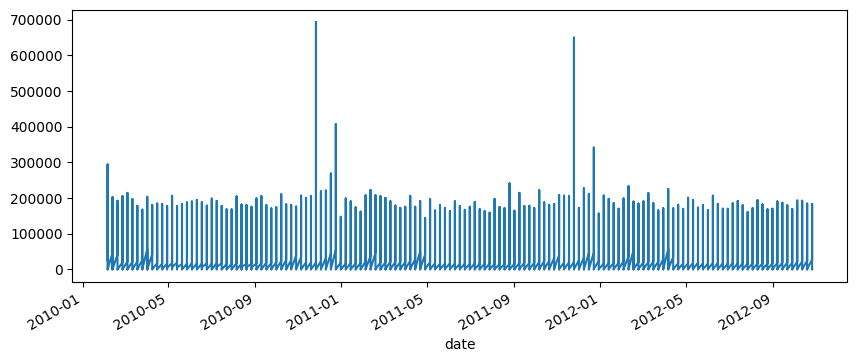

In [57]:
plt.figure(figsize=(10,4))
summary['weekly_sales'].plot()
plt.show()

In [58]:
df_week = summary.resample('W').agg({'weekly_sales': 'mean'})

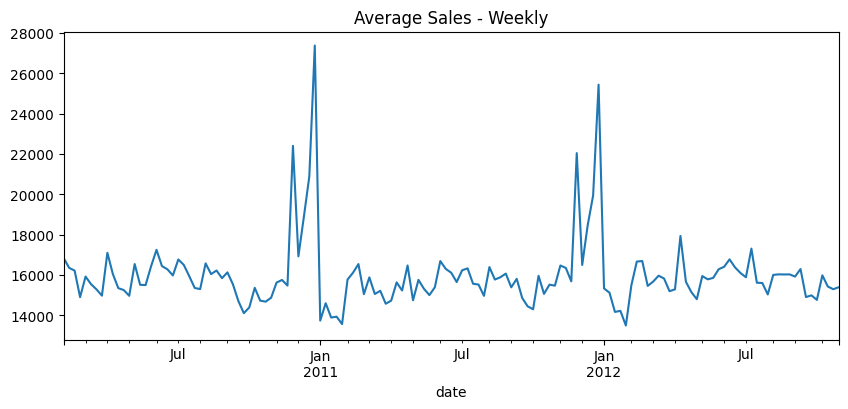

In [59]:
plt.figure(figsize=(10,4))
df_week['weekly_sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [60]:
autocorr_values = df_week['weekly_sales'].autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.3251912639045603


In [61]:
!pip install statsmodels -q
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
!pip install pmdarima -q
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

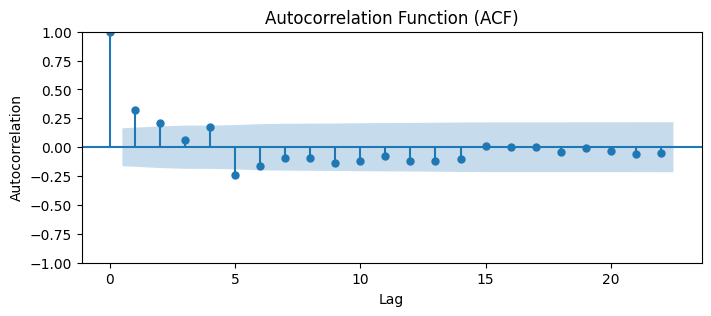

In [ ]:
if __name__ == "__main__":
    fig, ax = plt.subplots(figsize=(8, 3))
    plot_acf(df_week['weekly_sales'], ax=ax)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function (ACF)')

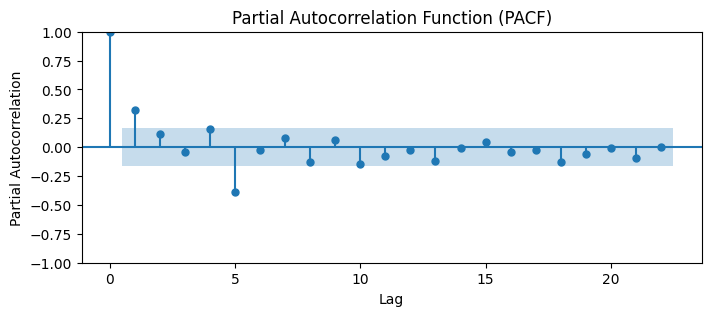

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
plot_pacf(df_week['weekly_sales'], ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

#### Stationarity Test
Augmented Dickey-Fuller (ADF) test
The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.  
The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

In [ ]:
result = adfuller(df_week['weekly_sales'])
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -5.930907234098228
p-value: 2.381944060010105e-07


In [ ]:
#creating difference values
df_week_diff = df_week['weekly_sales'].diff().dropna()

In [ ]:
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

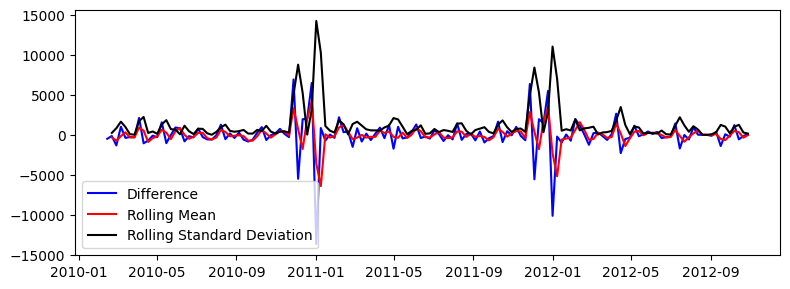

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [ ]:
result = adfuller(df_week_diff)
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -6.684689093702238
p-value: 4.255287387773872e-09


In [ ]:
decomposed = decompose(df_week['weekly_sales'].values, 'additive', m=4) #decomposing of weekly data 

In [ ]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend. In other words, the test is somewhat similar in spirit to the ADF test which is just mentioned above

In [ ]:
from statsmodels.tsa.stattools import kpss

In [ ]:
kpss_result = kpss(df_week['weekly_sales'])
kpss_statistic = kpss_result[0]
p_value = kpss_result[1]
print("KPSS Statistic:", adf_statistic)
print("p-value:", p_value)

KPSS Statistic: -6.684689093702238
p-value: 0.1


C:\Users\TruongVanThoi\AppData\Local\Temp\ipykernel_2736\1069273193.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_week['weekly_sales'])


#### Training model

In [ ]:
train_data = df_week [:int(0.7*(len(df_week )))]
test_data = df_week [int(0.7*(len(df_week ))):]

In [ ]:
model_auto_arima = auto_arima(train_data, trace=True, start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True, maxiter=200,
                  information_criterion='aic', stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore', approximation =False)
model_auto_arima.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1812.873, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1807.815, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1806.086, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1806.419, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1784.610, Time=0.09 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.662, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1805.367, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1807.863, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1809.025, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1786.162, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1803.952, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1805.971, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1804.559, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1802.050, Time=0.30 sec
 ARIMA(3,0,0)(0

ARIMA(maxiter=200, order=(0, 0, 4), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [ ]:
y_pred = model_auto_arima.predict(n_periods=len(test_data))

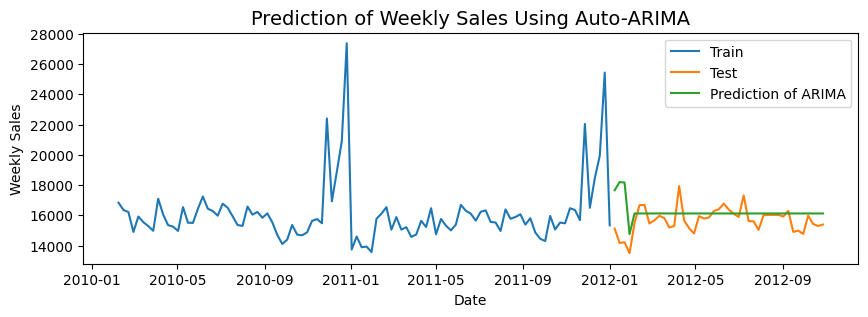

In [ ]:
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(10,3))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=14)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Weekly Sales', fontsize=10)
plt.show()

In [ ]:
mae = np.mean(np.abs(y_pred.values - test_data.values))
mape = np.mean(abs(y_pred.values - test_data.values)/test_data.values)
mse = np.mean((y_pred.values - test_data.values) ** 2)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 790.5041265001194
Mean Absolute Percentage Error (MAPE): 0.052038932766949
Mean Squared Error (MSE): 1390359.0985342085
Root Mean Squared Error (RMSE): 1179.134894121198


In [ ]:
# train_np = train_data.values.astype('float64')
# model = sm.tsa.ARIMA(train_np, order=(1, 0, 4))

# result = model.fit()

In [ ]:
# start_idx = len(train_data)
# end_idx = len(train_data) + len(test_data) - 1
# predictions = result.predict(start=start_idx, end=end_idx)

In [ ]:
# # Difference in case of non-stationary time series
# df_week_diff = df_week['weekly_sales'].diff().dropna()

In [ ]:
# train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
# test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [ ]:
# model_auto_arima = auto_arima(train_data_diff, start_p=0, start_q=0, start_P=0, start_Q=0,
#                   max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
#                   information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
#                   error_action='ignore',approximation = False)
# model_auto_arima.fit(train_data_diff)

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [ ]:
# y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
# y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
# plt.figure(figsize=(10,3))
# plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
# plt.plot(train_data_diff, label='Train')
# plt.plot(test_data_diff, label='Test')
# plt.plot(y_pred, label='Prediction of ARIMA')
# plt.legend(loc='best')
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Weekly Sales', fontsize=14)
# plt.show()

In [ ]:
# mae = np.mean(abs(y_pred.values - test_data_diff.values))
# mape = np.mean(abs(y_pred.values - test_data_diff.values)/test_data_diff.values)
# mse = np.mean((y_pred.values - test_data_diff.values) ** 2)
# rmse = np.sqrt(mse)

# print("Mean Absolute Error (MAE):", mae)
# print("Mean Absolute Percentage Error (MAPE):", mape)
# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)

### PROPHET
Prophet is open source software released by Facebook’s Core Data Science team.  
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet without extra regressor holiday

In [16]:
!pip install prophet -q

  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 1.1 MB/s eta 0:00:13
    --------------------------------------- 0.2/13.3 MB 2.3 MB/s eta 0:00:06
   - -------------------------------------- 0.4/13.3 MB 2.9 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/13.3 MB 4.2 MB/s eta 0:00:04
   --- ------------------------------------ 1.1/13.3 MB 4.6 MB/s eta 0:00:03
   ----- ---------------------------------- 1.7/13.3 MB 6.4 MB/s eta 0:00:02
   ------- -------------------------------- 2.7/13.3 MB 8.0 MB/s eta 0:00:02
   ---------- ----------------------------- 3.6/13.3 MB 9.7 MB/s eta 0:00:01
   ------------ --------------------------- 4.3/13.3 MB 10.1 MB/s eta 0:00:01
   --------------- ------------------------ 5.1/13.3 MB 10.9 MB/s eta 0:00:01
   ----------------- ---------------------- 5.9/13.3 MB 11.7 MB/s eta 0:00:01
   ----------------

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\TruongVanThoi\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python38\\site-packages\\prophet\\stan_model\\cmdstan-2.33.1\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_concurrent_skip_list_impl.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\TruongVanThoi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
from prophet import Prophet

c:\Users\TruongVanThoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [34]:
df_w = summary.set_index('date').resample('W').agg({'weekly_sales': 'mean'})

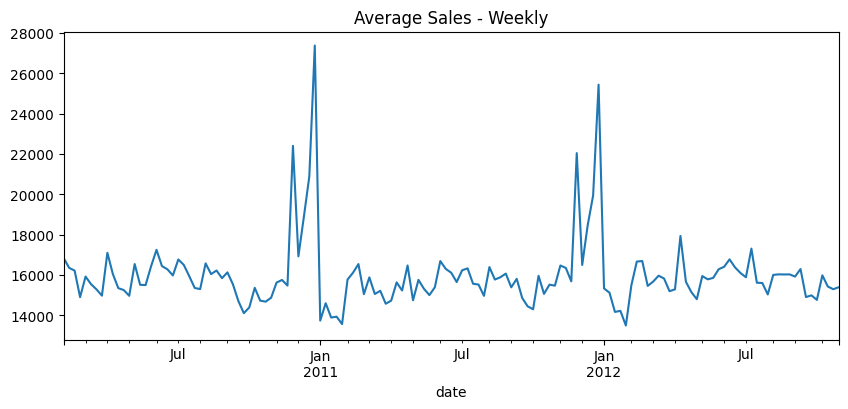

In [19]:
plt.figure(figsize=(10,4))
df_w['weekly_sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [36]:
df_w.reset_index(inplace=True)

In [57]:
df_w

,ds,y
0,2010-02-07,16836.167844
1,2010-02-14,16352.097463
2,2010-02-21,16216.964169
3,2010-02-28,14900.183209
4,2010-03-07,15921.438573
...,...,...
138,2012-09-30,14765.602147
139,2012-10-07,15983.552920
140,2012-10-14,15427.729090
141,2012-10-21,15295.743715


In [58]:
df_w.columns = ['ds','y']

In [59]:
m = Prophet()

In [60]:
m.fit(df_w)

22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
future = m.make_future_dataframe(periods=4, freq='W')

In [62]:
forecast = m.predict(future)

In [63]:
pd.merge(df_w, forecast, on='ds', how='inner')[['ds','y','yhat']]

,ds,y,yhat
0,2010-02-07,16836.167844,16269.352232
1,2010-02-14,16352.097463,16463.276070
2,2010-02-21,16216.964169,15985.022915
3,2010-02-28,14900.183209,15587.819563
4,2010-03-07,15921.438573,15519.867173
...,...,...,...
138,2012-09-30,14765.602147,14887.674156
139,2012-10-07,15983.552920,15349.989531
140,2012-10-14,15427.729090,15465.867495
141,2012-10-21,15295.743715,15208.173086


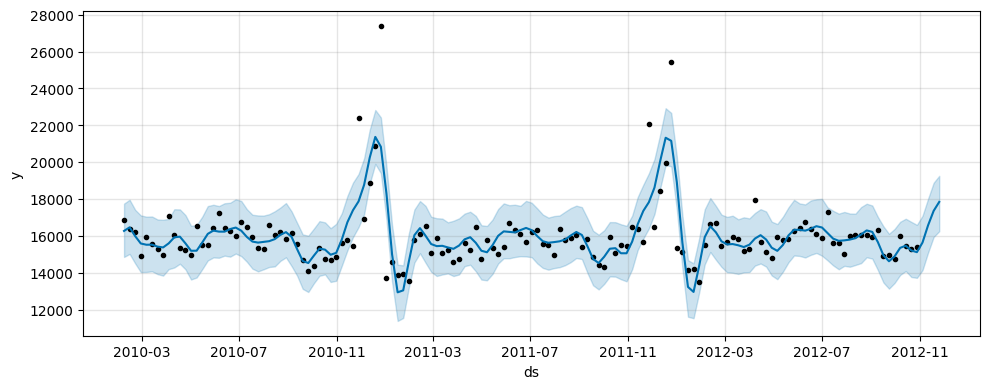

In [64]:
fig1 = m.plot(forecast, figsize=(10, 4))

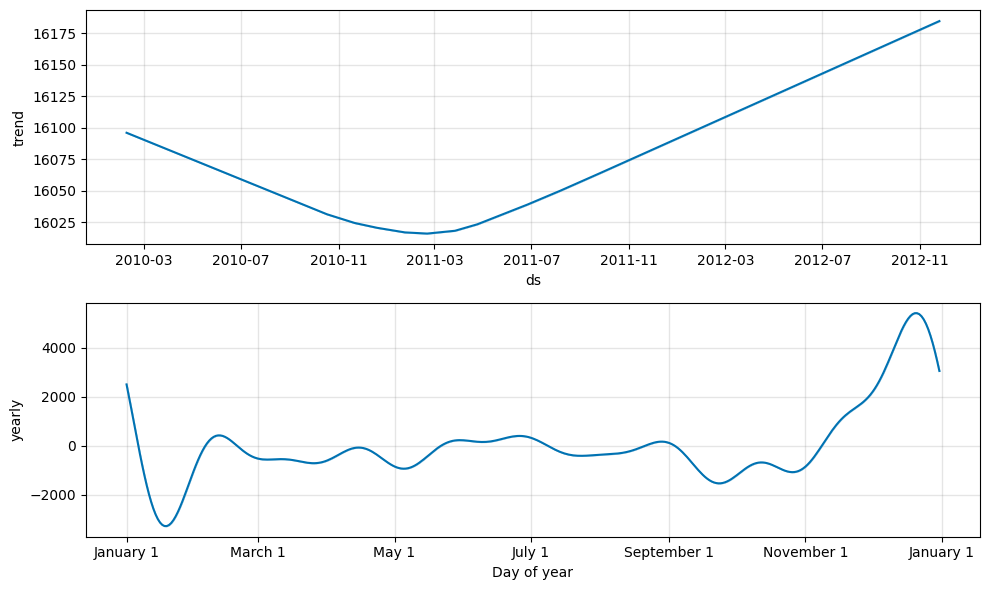

In [65]:
fig2 = m.plot_components(forecast, figsize=(10, 6))

In [66]:
from prophet.diagnostics import cross_validation, performance_metrics

In [67]:
df_cv = cross_validation(m, horizon='84 days')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/13 [00:00<?, ?it/s]

22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:55 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:00<00:03,  3.15it/s]22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:04,  2.32it/s]22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:01<00:03,  2.62it/s]22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:01<00:03,  2.62it/s]22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:57 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:01<00:02,  2.71it/s]22:01:57 - cmdstanpy - INFO - Chain [1] start processing
22:01:57 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:02<00:02,  2.63it/s]22:01:57 - cmdstanpy - INFO - Chain [1] start 

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,1.263572e+06,1124.087097,836.719682,0.052249,0.043871,0.052871,0.835897
1,21 days,6.911702e+05,831.366443,621.724327,0.038103,0.030291,0.038107,0.846154
2,28 days,1.378246e+06,1173.987116,671.217184,0.035806,0.022474,0.036727,0.912821
3,35 days,1.577789e+06,1256.100837,830.460381,0.051662,0.037050,0.050454,0.923077
4,42 days,1.719825e+06,1311.420925,712.846021,0.039847,0.025305,0.041288,0.923077
5,49 days,1.246801e+06,1116.602354,804.059281,0.049260,0.038886,0.050285,0.856410
6,56 days,8.224911e+05,906.912958,711.250606,0.044266,0.042763,0.045059,0.912821
7,63 days,6.632337e+05,814.391616,654.221927,0.040622,0.034310,0.040778,0.856410
8,70 days,1.421548e+06,1192.286856,672.508684,0.035751,0.026903,0.036764,0.912821
9,77 days,1.392655e+06,1180.107894,744.230176,0.046475,0.033986,0.045293,0.923077


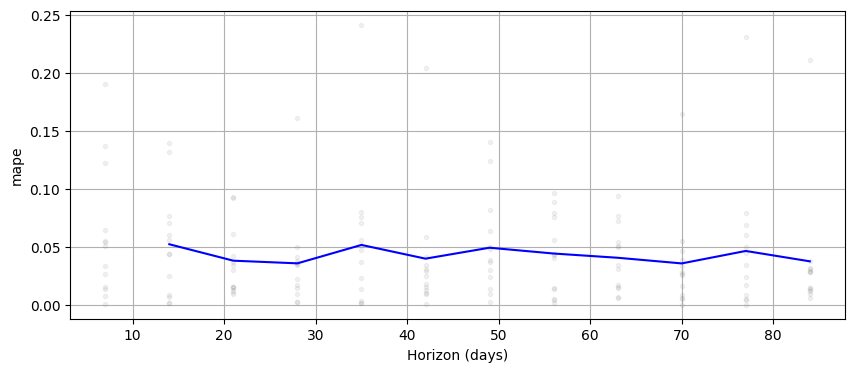

In [68]:
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape', figsize=(10, 4))

Prophet with extra regressor holiday

In [69]:
summary['occasion'].unique()

array(['Normal', 'Super Bowl', "Presidents' Day", 'Easter Day',
       'Labor Day', 'Thanksgiving', 'Before Christmas 1W', 'Christmas'],
      dtype=object)

In [70]:
df_wa = summary[['date','weekly_sales','occasion']]

In [71]:
hol = {
    'Normal': 0,
    'Super Bowl': 1,
    "Presidents' Day": 2,
    'Easter Day': 3,
    'Labor Day': 4,
    'Thanksgiving': 5,
    'Before Christmas 1W': 6,
    'Christmas': 7
}

In [72]:
df_wa['occasion'] = df_wa['occasion'].map(hol)

C:\Users\TruongVanThoi\AppData\Local\Temp\ipykernel_15936\2796861056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wa['occasion'] = df_wa['occasion'].map(hol)


In [73]:
df_wa = df_wa.set_index('date').resample('W').agg({'weekly_sales': 'mean', 'occasion': 'max'})

In [74]:
df_wa.reset_index(inplace=True)

In [75]:
df_wa.columns = ['ds', 'y', 'holiday']

In [76]:
m = Prophet()

In [77]:
m.add_regressor('holiday')

In [78]:
m.fit(df_wa)

22:02:09 - cmdstanpy - INFO - Chain [1] start processing


22:02:09 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=0, freq='W')
forecast = m.predict(future)

In [ ]:
forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']]

In [79]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='84 days')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/13 [00:00<?, ?it/s]22:02:24 - cmdstanpy - INFO - Chain [1] start processing
22:02:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:00<00:05,  2.11it/s]22:02:24 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:04,  2.50it/s]22:02:25 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:01<00:04,  2.46it/s]22:02:25 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:01<00:03,  2.52it/s]22:02:26 - cmdstanpy - INFO - Chain [1] start processing
22:02:26 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:02<00:03,  2.43it/s]22:02:26 - cmdstanpy - INFO - Chain [1] start processing
22:02:26 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:02<00:03,  2.28it/s]22:02:27

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,1.051789e+06,1025.567817,776.723305,0.049990,0.036962,0.050131,0.835897
1,21 days,1.558994e+06,1248.596928,840.637950,0.050963,0.040697,0.050145,0.846154
2,28 days,5.658485e+05,752.228997,556.224969,0.032808,0.019419,0.032794,0.912821
3,35 days,5.905776e+05,768.490447,648.428013,0.040459,0.031867,0.040547,0.789744
4,42 days,5.401116e+05,734.922843,588.327620,0.036155,0.031593,0.036345,0.835897
5,49 days,1.293844e+06,1137.472653,812.360848,0.049919,0.038231,0.051501,0.846154
6,56 days,6.519176e+05,807.414127,630.692685,0.039611,0.033654,0.040756,0.846154
7,63 days,1.258137e+06,1121.666895,781.819928,0.047809,0.040223,0.047279,0.779487
8,70 days,6.379189e+05,798.698236,565.038863,0.032529,0.029109,0.032680,0.902564
9,77 days,5.028982e+05,709.153123,564.709278,0.035204,0.025387,0.035244,0.856410


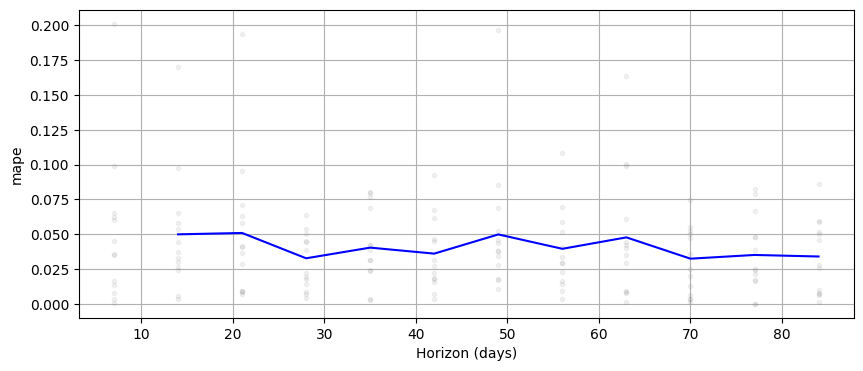

In [80]:
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape', figsize=(10, 4))

## Machine Learning Model

In [25]:
! pip install xgboost -q


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\TruongVanThoi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from matplotlib import pyplot

### Linear Regression

In [27]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

LinearRegression()

In [28]:
linear_pred = linear_model.predict(X_val)

In [29]:
evaluation_metrics(y_val,linear_pred)

Mean Squared Error = 446234387.74002707
Mean Absolute Error = 14308.822182652011
Root Mean Squared Error = 21124.260643630278
r2 score = 0.09690158546471073


### Decision Tree

In [31]:
dt = DecisionTreeRegressor(max_depth=20)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20)

In [32]:
# get importance
importance = dt.feature_importances_

In [44]:
fts = X_train.columns.values

In [52]:
# summarize feature importance
feature_scores = list(zip(fts, importance))
sorted_feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
for i, v in sorted_feature_scores:
    print('Feature: %s - %.5f' % (i, v))

Feature: dept - 0.62395
Feature: size - 0.18643
Feature: store - 0.04586
Feature: cpi - 0.03218
Feature: _thanksgiving - 0.02433
Feature: weekofyear - 0.02020
Feature: unemployment - 0.01308
Feature: _b - 0.01128
Feature: _christmas - 0.01116
Feature: temperature - 0.01037
Feature: _a - 0.00517
Feature: _normal - 0.00488
Feature: fuel_price - 0.00463
Feature: markdown3 - 0.00134
Feature: isholiday - 0.00125
Feature: _before christmas 1w - 0.00089
Feature: markdown4 - 0.00064
Feature: _c - 0.00048
Feature: year - 0.00040
Feature: markdown2 - 0.00037
Feature: markdown5 - 0.00033
Feature: markdown1 - 0.00031
Feature: _labor day - 0.00016
Feature: _super bowl - 0.00013
Feature: _easter day - 0.00010
Feature: _presidents' day - 0.00010


In [62]:
# pick up top 10 features to train model
fts_1 = [item[0] for item in sorted_feature_scores[:10]]

In [68]:
X_train_1 = X_train[fts_1]
X_val_1 = X_val[fts_1]

In [66]:
dt1 = DecisionTreeRegressor(max_depth=20)
dt1.fit(X_train_1, y_train)

DecisionTreeRegressor(max_depth=20)

In [70]:
dt_pred = dt1.predict(X_val_1)

In [71]:
evaluation_metrics(y_val, dt_pred)

Mean Squared Error = 43485057.93753937
Mean Absolute Error = 2844.3757988735542
Root Mean Squared Error = 6594.320127013805
r2 score = 0.9119940373079312


### Random Forest

In [72]:
rf = RandomForestRegressor(n_estimators=50, random_state=1)
model = rf.fit(X_train, y_train)

In [74]:
# get importance
importance = rf.feature_importances_

In [75]:
# summarize feature importance
feature_scores = list(zip(fts, importance))
sorted_feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
for i, v in sorted_feature_scores:
    print('Feature: %s - %.5f' % (i, v))

Feature: dept - 0.61590
Feature: size - 0.19170
Feature: store - 0.04867
Feature: cpi - 0.03106
Feature: _thanksgiving - 0.02375
Feature: weekofyear - 0.02081
Feature: unemployment - 0.01479
Feature: temperature - 0.01218
Feature: _b - 0.01086
Feature: _christmas - 0.01075
Feature: fuel_price - 0.00540
Feature: _normal - 0.00399
Feature: _a - 0.00315
Feature: markdown3 - 0.00187
Feature: _before christmas 1w - 0.00089
Feature: isholiday - 0.00074
Feature: markdown4 - 0.00064
Feature: markdown2 - 0.00059
Feature: markdown5 - 0.00058
Feature: markdown1 - 0.00044
Feature: _c - 0.00038
Feature: year - 0.00027
Feature: _easter day - 0.00018
Feature: _labor day - 0.00016
Feature: _presidents' day - 0.00015
Feature: _super bowl - 0.00011


In [76]:
# pick up top 10 features to train model
fts_1 = [item[0] for item in sorted_feature_scores[:10]]

In [77]:
X_train_1 = X_train[fts_1]
X_val_1 = X_val[fts_1]

In [78]:
rf_1 = RandomForestRegressor(n_estimators=50, random_state=1)
model = rf_1.fit(X_train_1, y_train)

In [80]:
y_pred = rf_1.predict(X_val_1)

In [81]:
evaluation_metrics(y_val, y_pred)

Mean Squared Error = 24153775.42994703
Mean Absolute Error = 2240.6607834743413
Root Mean Squared Error = 4914.649064780418
r2 score = 0.9511170880256435


### XG Boost Regression

In [82]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [85]:
# get importance
importance = xgb_model.feature_importances_

In [86]:
# summarize feature importance
feature_scores = list(zip(fts, importance))
sorted_feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
for i, v in sorted_feature_scores:
    print('Feature: %s - %.5f' % (i, v))

Feature: _thanksgiving - 0.35617
Feature: _b - 0.16651
Feature: dept - 0.13248
Feature: size - 0.12156
Feature: store - 0.03755
Feature: _christmas - 0.03208
Feature: cpi - 0.03065
Feature: weekofyear - 0.01871
Feature: _normal - 0.01728
Feature: year - 0.01467
Feature: _a - 0.01174
Feature: _c - 0.01117
Feature: unemployment - 0.00847
Feature: temperature - 0.00751
Feature: isholiday - 0.00712
Feature: _easter day - 0.00661
Feature: markdown3 - 0.00332
Feature: _before christmas 1w - 0.00316
Feature: markdown2 - 0.00297
Feature: fuel_price - 0.00264
Feature: markdown1 - 0.00228
Feature: markdown4 - 0.00201
Feature: markdown5 - 0.00192
Feature: _presidents' day - 0.00071
Feature: _labor day - 0.00042
Feature: _super bowl - 0.00031


In [87]:
# pick up top 10 features to train model
fts_1 = [item[0] for item in sorted_feature_scores[:10]]

In [88]:
X_train_1 = X_train[fts_1]
X_val_1 = X_val[fts_1]

In [89]:
xgb_1 = XGBRegressor()
xgb_1.fit(X_train_1,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [90]:
xgb_pred = xgb_1.predict(X_val_1)

In [91]:
evaluation_metrics(y_val, xgb_pred)

Mean Squared Error = 29310671.82190201
Mean Absolute Error = 3148.946024363806
Root Mean Squared Error = 5413.933119452254
r2 score = 0.9406804540874036
